# 生成式预训练语言模型：理论与实战
深蓝学院 课程 
课程链接：https://www.shenlanxueyuan.com/course/620

作者 **黄佳**

## 第1步：构建实验语料库

In [1]:
# 定义一个句子列表，后面会用这些句子来训练CBOW和Skip-Gram模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成词汇
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词汇映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词汇
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print("词汇表：", word_list) # 输出词汇表
print("词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print("索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print("词汇表大小：", voc_size) # 输出词汇表大小

词汇表： ['Student', 'is', 'Mazong', 'Boss', 'Xiaoxue', 'Kage', 'Xiaobing', 'Teacher', 'Niuzong']
词汇到索引的字典： {'Student': 0, 'is': 1, 'Mazong': 2, 'Boss': 3, 'Xiaoxue': 4, 'Kage': 5, 'Xiaobing': 6, 'Teacher': 7, 'Niuzong': 8}
索引到词汇的字典： {0: 'Student', 1: 'is', 2: 'Mazong', 3: 'Boss', 4: 'Xiaoxue', 5: 'Kage', 6: 'Xiaobing', 7: 'Teacher', 8: 'Niuzong'}
词汇表大小： 9


## 第2步：生成Skip-Gram训练数据

In [2]:
# 生成Skip-Gram训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各N个单词作为相邻单词
            for neighbor in sentence[max(idx - window_size, 0): 
                        min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前单词本身
                    # 将相邻单词与当前单词作为一组训练数据
                    data.append((neighbor, word))
    return data
# 使用函数创建Skip-Gram训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印未编码的Skip-Gram数据样例
print("Skip-Gram数据样例（未编码）：", skipgram_data)

Skip-Gram数据样例（未编码）： [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is'), ('Teacher', 'is'), ('Kage', 'Teacher'), ('is', 'Teacher'), ('is', 'Mazong'), ('Boss', 'Mazong'), ('Mazong', 'is'), ('Boss', 'is'), ('Mazong', 'Boss'), ('is', 'Boss'), ('is', 'Niuzong'), ('Boss', 'Niuzong'), ('Niuzong', 'is'), ('Boss', 'is'), ('Niuzong', 'Boss'), ('is', 'Boss'), ('is', 'Xiaobing'), ('Student', 'Xiaobing'), ('Xiaobing', 'is'), ('Student', 'is'), ('Xiaobing', 'Student'), ('is', 'Student'), ('is', 'Xiaoxue'), ('Student', 'Xiaoxue'), ('Xiaoxue', 'is'), ('Student', 'is'), ('Xiaoxue', 'Student'), ('is', 'Student')]


## 第3步：对Skip-Gram数据进行One-Hot编码

In [3]:
# 定义One-Hot编码函数
import torch # 导入torch库
def one_hot_encoding(word, word_to_idx):
    # 创建一个全为0的张量，长度与词汇表大小相同
    tensor = torch.zeros(len(word_to_idx))  
    tensor[word_to_idx[word]] = 1  # 将对应词汇的索引位置置为1
    return tensor  # 返回生成的One-Hot向量

# 展示One-Hot编码前后的数据
word_example = "Teacher"
print("One-Hot编码前的单词：", word_example)
print("One-Hot编码后的向量：", one_hot_encoding(word_example, word_to_idx))

# 展示编码后的Skip-Gram数据样例
print("Skip-Gram数据样例（已编码）：", [(one_hot_encoding(context, word_to_idx), 
          word_to_idx[target]) for context, target in skipgram_data[:3]])

One-Hot编码前的单词： Teacher
One-Hot编码后的向量： tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.])
Skip-Gram数据样例（已编码）： [(tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 5), (tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 5), (tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 1)]


## 第4步：定义Skip-Gram模型

In [4]:
# 定义Skip-Gram模型
import torch.nn as nn # 导入neural network
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)  
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)  

    def forward(self, X): # X : [batch_size, voc_size]        
         # 生成隐藏层：[batch_size, embedding_size]
        hidden_layer = self.input_to_hidden(X) 
        # 生成输出层：[batch_size, voc_size]
        output_layer = self.hidden_to_output(hidden_layer)  
        return output_layer
    
embedding_size = 2 # 设定嵌入层的大小，这里选择2是为了方便展示
skipgram_model = SkipGram(voc_size,embedding_size)  # 实例化SkipGram模型
print("Skip-Gram模型：", skipgram_model)

Skip-Gram模型： SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


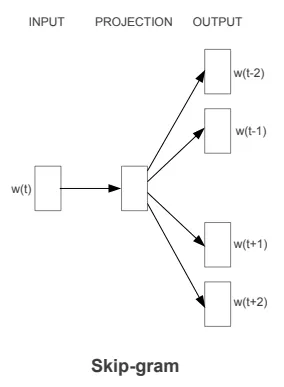

## 第5步：训练Skip-Gram模型

Epoch: 100, Loss: 2.1821006774902343
Epoch: 200, Loss: 2.1476088722546893
Epoch: 300, Loss: 2.1057803789774576
Epoch: 400, Loss: 2.0551783363024394
Epoch: 500, Loss: 2.001389334599177
Epoch: 600, Loss: 1.954955240090688
Epoch: 700, Loss: 1.9216339667638143
Epoch: 800, Loss: 1.8994188825289409
Epoch: 900, Loss: 1.883852987488111
Epoch: 1000, Loss: 1.871559727191925


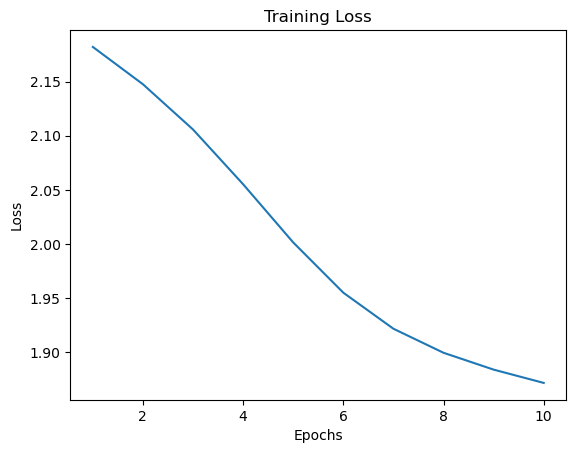

In [5]:
# 训练Skip-Gram模型
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)  

# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for context, target in skipgram_data:        
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0) # 将中心词转换为One-Hot向量   
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long) # 将周围词转换为索引值   
        y_pred = skipgram_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每100轮的损失，并记录损失
        print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(skipgram_data)}")  
        loss_values.append(loss_sum / len(skipgram_data))

# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入matplotlib
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title('Training Loss') # 图题
plt.xlabel('Epochs') # X轴Label
plt.ylabel('Loss') # Y轴Label
plt.show() # 显示图

## 第6步：输出Skip-Gram词向量

In [6]:
# 输出Skip-Gram习得的词嵌入
print("\nSkip-Gram词嵌入:")
for word, idx in word_to_idx.items(): # 输出每个单词的嵌入向量
    print(f"{word}: \
    {skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()}")  


Skip-Gram词嵌入:
Student:     [0.7595092  0.24590118]
is:     [-0.47879416 -0.25787747]
Mazong:     [0.38106963 0.3967126 ]
Boss:     [0.96846765 0.6014609 ]
Xiaoxue:     [0.4819389 0.5664613]
Kage:     [0.37162718 0.73662686]
Xiaobing:     [0.41746804 0.7186032 ]
Teacher:     [0.24550691 0.37696487]
Niuzong:     [0.4493814  0.29012886]


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
/home/huangjia/ENTER/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/huangjia/ENTER/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/huangjia/ENTER/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/huangjia/ENTER/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
/home/huangjia/ENTER/l

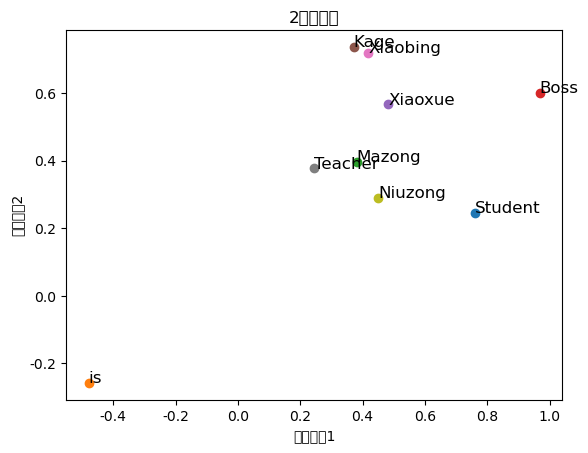

In [7]:
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
# 绘制二维词向量图
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[:, \
            idx].detach().numpy() # 获取每个单词的嵌入向量
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title('2维词嵌入') # 图题
plt.xlabel('向量维度1') # X轴Label
plt.ylabel('向量维度2') # Y轴Label
plt.show() # 显示图